In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import csv
import scipy
import astropy

def merge_windows(windows):
    # Sort the windows based on the start time
    windows.sort(key=lambda x: x[0])

    merged_windows = [windows[0]]

    for current_start, current_end in windows[1:]:
        last_merged_start, last_merged_end = merged_windows[-1]

        # Check if the current window overlaps with the last merged window
        if current_start <= last_merged_end:
            # Merge the windows by extending the end time of the last merged window
            merged_windows[-1] = (last_merged_start, max(last_merged_end, current_end))
        else:
            # No overlap, add the current window to the merged list
            merged_windows.append((current_start, current_end))
                
    return merged_windows

from astropy.timeseries import LombScargle
def remove_detected_windows(time_array, data_array, detected_windows):
    """
    Removes data corresponding to abnormal windows from the time and observation arrays.
    
    Parameters:
        time_array (np.ndarray): Array of time values.
        data_array (np.ndarray): Array of observation values.
        detected_windows (list of tuples): List of abnormal windows, each defined by a tuple (start_index, end_index).
    
    Returns:
        tuple: Filtered time_array and data_array with abnormal data removed.
    """
    if len(time_array) != len(data_array):
        raise ValueError("time_array and data_array must have the same length.")
    
    # Create a mask of valid data points
    valid_mask = np.ones(len(time_array), dtype=bool)
    
    # Mark indices in abnormal windows as invalid
    for start_idx, end_idx in detected_windows:
        valid_mask[start_idx:end_idx + 1] = False
    
    # Apply the mask to both arrays
    filtered_time = time_array[valid_mask]
    filtered_observation = data_array[valid_mask]
    
    return filtered_time, filtered_observation

In [2]:
# Representing long-period seismograms as a sum of decaying cosinusoids ()
def get_simulated_seismogram(
    mode_num = 7,
    amplitude_list = [1, 1, 1, 1, 1, 1, 1],
    period_list = [100, 200, 300, 400, 500, 600, 700],
    phase_list = [0, 0, 0, 0, 0, 0, 0],
    quality_factor_list = [1500, 1500, 1500, 1500, 1500, 1500, 1500],
    duration = 120000,
    dt = 1.0/6.625
    ):
    """
    mode_num: number of modes to simulate
    amplitude_list: list of amplitudes for each mode
    period_list: list of periods for each mode
    phase_list: list of phases for each mode
    quality_factor_list: Q for each mode
    duration: duration of the seismogram in seconds
    dt: time step in seconds
    """
    t = np.arange(0, duration, dt)
    seismogram = np.zeros_like(t)
    freq_list = 1.0/np.array(period_list)
    for i in range(mode_num):
        attenuation_factor = 2*np.pi*freq_list[i]/quality_factor_list[i]
        seismogram += amplitude_list[i]*np.exp(-attenuation_factor*t)*np.cos(2*np.pi*freq_list[i]*t + phase_list[i])
    
    return t, seismogram

In [3]:
# MW setting with 2 overtones
mode_num = 27
amplitude_list = np.ones(mode_num)
# period list from Gudkova and Raevskii (2013) based on the model from Weber et al. (2011).
period_list = [16.15*60.0, 10.47*60.0, 8.163*60.0, 6.812*60.0, 5.883*60.0, 5.192*60.0, 4.655*60.0, 4.224*60.0, 3.870*60.0,
               8.950*60.0, 6.581*60.0, 5.239*60.0, 4.378*60.0, 3.776*60.0, 3.332*60.0, 2.992*60.0, 2.723*60.0, 2.506*60.0,
               5.153*60.0, 4.950*60.0, 3.926*60.0, 3.376*60.0, 3.033*60.0, 2.771*60.0, 2.554*60.0, 2.369*60.0, 2.208*60.0]

phase_list = np.zeros(mode_num)
quality_factor_list = np.ones(mode_num) * 1500
duration = 40*3600
dt = 1.0/6.625
t, seismogram = get_simulated_seismogram(mode_num, amplitude_list, period_list, phase_list, quality_factor_list, duration, dt)

In [4]:
def plot_seismogram_with_gaps(filtered_t, filtered_seismogram, gap_threshold=6.625):
    # Detect gaps based on the filtered time array
    segments = []
    current_segment = [0]

    for i in range(1, len(filtered_t)):
        if filtered_t[i] - filtered_t[i - 1] > gap_threshold:
            current_segment.append(i - 1)
            segments.append(current_segment)
            current_segment = [i]
    current_segment.append(len(filtered_t) - 1)
    segments.append(current_segment)

    for segment in segments:
        start, end = segment
        plt.plot(
            filtered_t[start:end + 1],
            filtered_seismogram[start:end + 1],
            color='k'
        )
    return

In [21]:
def plot_polluted_waveform(t, dt, seismogram, polluted_seismogram, disturbance_windows, freqmin=1*1e-3, freqmax=12*1e-3, window='hanning', pollute_rate = None):
    """
    t: time array
    dt: time step
    seismogram: seismogram array
    """
    n = len(seismogram)
    f = np.fft.fftfreq(n, dt)
    f = f[:n//2]

    if window == 'hanning':
        windowed_seismogram = seismogram * np.hanning(n)
    else:
        windowed_seismogram = seismogram
    
    ori_spectrum = np.abs(np.fft.fft(seismogram))[:n//2]
    spectrum = np.abs(np.fft.fft(windowed_seismogram))[:n//2]
    plt.figure(figsize=(18, 22))
    plt.subplot(6, 1, 1)
    plt.plot(t, seismogram, color='k')
    plt.text(-0.05, 1.0, '(a)', transform=plt.gca().transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylabel('Amplitude', fontsize=16)
    #plt.title('Original seismogram', fontsize=16)
    plt.text(0.5, 0.975, 'Original seismogram', transform=plt.gca().transAxes, fontsize=20, va='top', ha='center', backgroundcolor='white', zorder=10)
    plt.xlim(0, t[-1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.subplot(6, 1, 2)
    plt.plot(f,ori_spectrum, color='k')
    plt.xlabel('Frequency (Hz)', fontsize=16)
    plt.ylabel('Amplitude', fontsize=16)
    plt.xlim(freqmin, freqmax)
    #plt.title('Original spectrum', fontsize=16)
    plt.text(0.5, 0.975, 'Original spectrum', transform=plt.gca().transAxes, fontsize=20, va='top', ha='center', backgroundcolor='white', zorder=10)
    plt.text(-0.05, 1.0, '(b)', transform=plt.gca().transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
    for mode in period_list:
        plt.axvline(1.0/mode, color='orange', linestyle='--',lw=2,zorder=-1)
    # add a label for vertical line
    plt.axvline(0, color='orange', linestyle='--', label='Eigenfrequencies',lw=2,zorder=-1)
    plt.legend(loc='upper right', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.subplot(6, 1, 3)
    plt.plot(t, windowed_seismogram, color='k')
    plt.text(-0.05, 1.0, '(c)', transform=plt.gca().transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
    
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylabel('Amplitude', fontsize=16)
    #plt.title('Hanning windowed seismogram', fontsize=16)
    plt.text(0.5, 0.975, 'Hanning windowed seismogram', transform=plt.gca().transAxes, fontsize=20, va='top', ha='center', backgroundcolor='white', zorder=10)
    
    plt.xlim(0, t[-1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.subplot(6, 1, 4)
    plt.plot(f,spectrum, color='k')
    plt.xlabel('Frequency (Hz)', fontsize=16)
    plt.ylabel('Amplitude', fontsize=16)
    plt.xlim(freqmin, freqmax)
    #plt.title('Hanning windowed spectrum', fontsize=16)
    plt.text(0.5, 0.975, 'Hanning windowed spectrum', transform=plt.gca().transAxes, fontsize=20, va='top', ha='center', backgroundcolor='white', zorder=10)
    plt.text(-0.05, 1.0, '(d)', transform=plt.gca().transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
    for mode in period_list:
        plt.axvline(1.0/mode, color='orange', linestyle='--', lw=2,zorder=-1)
    # add a label for vertical line
    plt.axvline(0, color='orange', linestyle='--', label='Eigenfrequencies',lw=2,zorder=-1)
    #plt.legend(loc='upper right', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.subplot(6, 1, 5)
    plt.text(-0.05, 1.0, '(e)', transform=plt.gca().transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
    if window == 'hanning':
        windowed_polluted_seismogram = polluted_seismogram * np.hanning(n)
    else:
        windowed_polluted_seismogram = polluted_seismogram
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.plot(t, windowed_polluted_seismogram, color='k')
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylabel('Amplitude', fontsize=16)
    #plt.title('Seismogram with {:.0f}% data polluted by disturbances'.format(pollute_rate*100), fontsize=16)
    plt.text(0.5, 0.975, 'Seismogram with {:.0f}% data polluted by disturbances'.format(pollute_rate*100), transform=plt.gca().transAxes, fontsize=20, va='top', ha='center', backgroundcolor='white', zorder=10)
    for window in disturbance_windows:
        plt.axvspan(window[0]*dt, window[1]*dt, color='pink', alpha=0.5, ymax=0.8, ymin=0.2)
    # add a label for the disturbancees
    plt.axvspan(0, 0, color='pink', alpha=0.5, label='Disturbances')
    plt.legend(loc='upper right', fontsize=14)
    plt.xlim(0, t[-1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    spectrum_polluted = np.abs(np.fft.fft(windowed_polluted_seismogram))[:n//2]
    plt.subplot(6, 1, 6)
    plt.text(-0.05, 1.0, '(f)', transform=plt.gca().transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
    plt.plot(f, spectrum_polluted, color='k')
    plt.xlabel('Frequency (Hz)', fontsize=16)
    plt.ylabel('Amplitude', fontsize=16)
    plt.xlim(freqmin, freqmax)
    #plt.title('Polluted spectrum', fontsize=16)
    plt.text(0.5, 0.975, 'Polluted spectrum', transform=plt.gca().transAxes, fontsize=20, va='top', ha='center', backgroundcolor='white', zorder=10)
    for mode in period_list:
        plt.axvline(1.0/mode, color='orange', linestyle='--', lw=2,zorder=-1)
    # add a label for vertical line
    plt.axvline(0, color='orange', linestyle='--', label='Eigenfrequencies',lw=2,zorder=-1)
    #plt.legend(loc='upper right', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig('Figure_2.png'.format(pollute_rate), dpi=600)
    plt.show()
    plt.close()

In [22]:
disturbance_data = np.load('disturbance_data_for_random_sample_usage.npy', allow_pickle=True)

In [23]:
# fix the random seed so that we can reproduce the results
np.random.seed(0)

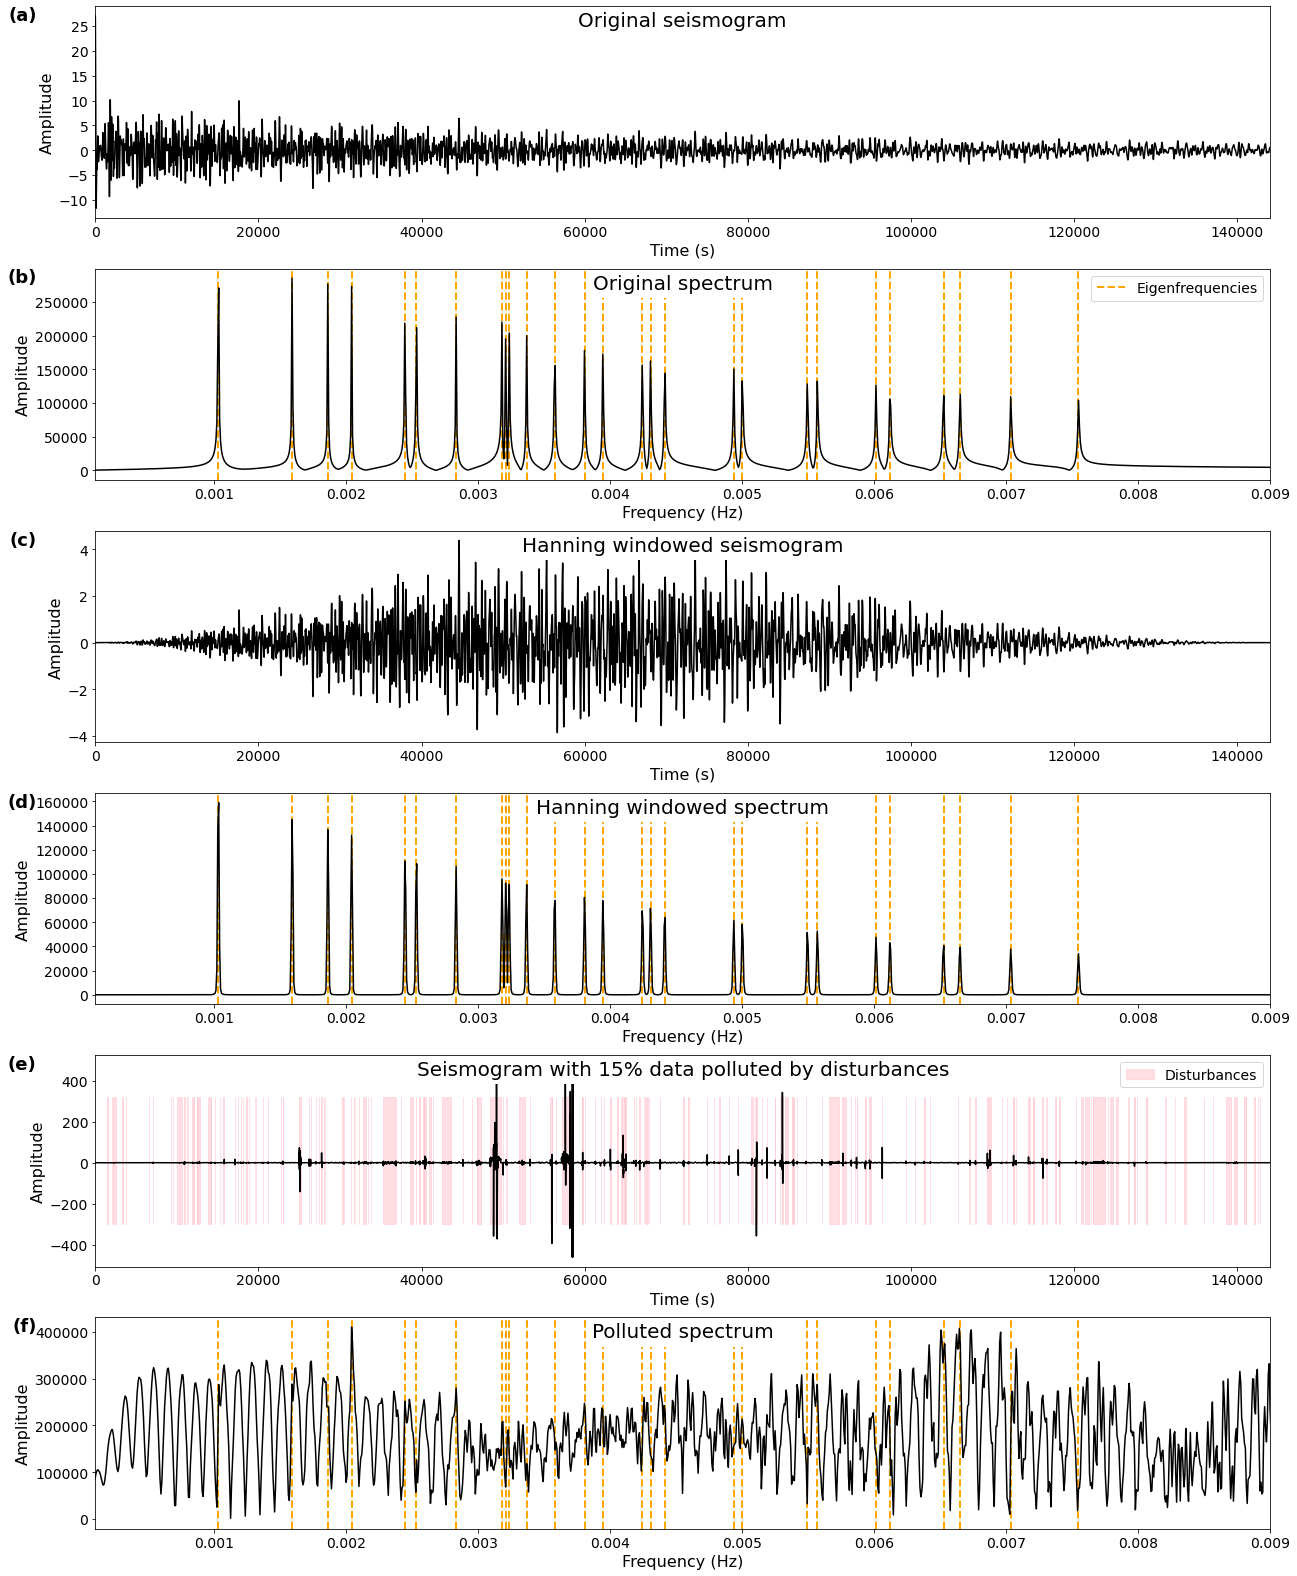

In [24]:
pollute_rate = 0.15
polluted_seismogram = seismogram.copy()
disturbance_windows = []
while True:
    # randomly select disturbancees until most of the seismogram is polluted to
    sampled_disturbance = np.random.choice(disturbance_data).copy().astype(np.float64)
    sampled_disturbance -= np.mean(sampled_disturbance)
    disturbance_start = np.random.randint(50, len(seismogram)-50)
    t_disturbance_len = len(sampled_disturbance)
    if t_disturbance_len > 9600:
        sampled_disturbance = sampled_disturbance[:9600]
        t_disturbance_len = 9600
        sampled_disturbance -= np.mean(sampled_disturbance)
    try:
        polluted_seismogram[disturbance_start:disturbance_start+t_disturbance_len] += sampled_disturbance
    except:
        continue
    disturbance_windows.append([disturbance_start, disturbance_start+t_disturbance_len])

    disturbance_windows = merge_windows(disturbance_windows)
    # calculate the polluted rate
    cur_polluted_rate = sum([win[1]-win[0] for win in disturbance_windows])/len(seismogram)
    if cur_polluted_rate >= pollute_rate:
        break
plot_polluted_waveform(t, 1.0/6.625, seismogram, polluted_seismogram, disturbance_windows, window='hanning', freqmin=0.1*1e-3, freqmax=9*1e-3, pollute_rate = cur_polluted_rate)